In [42]:
!pip install transformers
#!pip install transformers[all-deps]

In [43]:
from transformers import RobertaTokenizer, RobertaForQuestionAnswering, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap

In [44]:
# initialize
RANDOM_SEED = 42
MAX_LEN = 200
BATCH_SIZE = 16
DATASET_PATH = '/content/drive/My Drive/UNI/7/SoftwareModels/PerFoo/project/clean-reviews.csv'
DATASET_PATH = '/content/drive/My Drive/UNI/7/SoftwareModels/PerFoo/project/data.csv'
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [45]:
# load dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv(DATASET_PATH)
df = df[0:10000]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(df.head())
print(df.shape)
print("\n".join(wrap(df['review'][200])))

  id_review                                             review      title  \
0   R100000  Nos encant��! !! Delicioso, excelente atenci��...  Muy buena   
1  R1000000                                              Bueno        NaN   
2  R1000001                                         Buen lugar        NaN   
3  R1000002                                              Bueno        NaN   
4  R1000003                             Se come bien parrillas        NaN   

   Suma de score  Suma de service      platform                id_nick  
0              5            40012   tripadvisor               33carlab  
1              5           265714  googleplaces  104152718589528054490  
2              5           265714  googleplaces  115091044120783070217  
3              4           265714  googleplaces  100583222751224055407  
4              5           265714  googleplaces  116683193740858649916  
(10000, 7)
Un lugar acogedor,  buena atención, potajes de primera y cumple con
los protocolos de bi

In [52]:
# TOKENIZACION
from transformers import BertModel, BertTokenizer

PRE_TRAINED_MODEL_NAME = "dccuchile/bert-base-spanish-wwm-uncased" #"IIC/roberta-base-spanish-sqac"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
#tokenizer = RobertaTokenizer.from_pretrained("IIC/roberta-base-spanish-sqac")

In [53]:
# tokenization test
sample = 'Muy buena presentación 👍👍👍 y servicio sin embargo exageradamente costoso y no se informa ennla carta lis precios,Muy buena presentación y servicio'
tokens = tokenizer.tokenize(sample)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print('Frase: ', sample)
print('Tokens: ', tokens)
print('Numerics tokens: ', token_ids)

Frase:  Muy buena presentación 👍👍👍 y servicio sin embargo exageradamente costoso y no se informa ennla carta lis precios,Muy buena presentación y servicio
Tokens:  ['muy', 'buena', 'presentación', '[UNK]', 'y', 'servicio', 'sin', 'embargo', 'exager', '##adamente', 'costoso', 'y', 'no', 'se', 'informa', 'en', '##n', '##la', 'carta', 'lis', 'precios', ',', 'muy', 'buena', 'presentación', 'y', 'servicio']
Numerics tokens:  [1355, 2245, 4903, 3, 1040, 2809, 1320, 2338, 11622, 3080, 27378, 1040, 1054, 1057, 5044, 1035, 30959, 1095, 3350, 4326, 4661, 1019, 1355, 2245, 4903, 1040, 2809]


In [34]:
#!pip install nltk
import nltk
import nltk.data
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
sample = "Muy buena presentación y servicio sin embargo exageradamente costoso y no se informa ennla carta lis precios,Muy buena presentación y servicio"
sample = "Hola amigos. Gracias por ver este video. Saludos"
tokenizer = nltk.data.load('tokenizers/punkt/spanish.pickle')
print(tokenizer.tokenize(sample))

['Hola amigos.', 'Gracias por ver este video.', 'Saludos']


-------------------------------------

In [60]:
# codificatio for BETO
sample = 'Muy buena presentación 👍👍👍 y servicio sin embargo exageradamente costoso y no se informa ennla carta lis precios,Muy buena presentación y servicio'

encoding = tokenizer.encode_plus(
    sample,
    max_length = 100,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [62]:
encoding.keys()
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'muy', 'buena', 'presentación', '[UNK]', 'y', 'servicio', 'sin', 'embargo', 'exager', '##adamente', 'costoso', 'y', 'no', 'se', 'informa', 'en', '##n', '##la', 'carta', 'lis', 'precios', ',', 'muy', 'buena', 'presentación', 'y', 'servicio', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
tensor([    4,  1355,  2245,  4903,     3,  1040,  2809,  1320,  2338, 11622,
         3080, 27378,  

In [63]:
# models

class BETOSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)


  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output


In [70]:
print(df['review'])

0       Nos encant��! !! Delicioso, excelente atenci��...
1                                                   Bueno
2                                              Buen lugar
3                                                   Bueno
4                                  Se come bien parrillas
                              ...                        
9995                   Sitio tranquilo y excelente vista.
9996    Bien.....Felicitaciones. ..buena atención. ......
9997    Muy amable el personal!!! El lugar es espectac...
9998                              Excelente frente al mar
9999    Agradable lugar, faltaria mejorar la atencion ...
Name: review, Length: 10000, dtype: object


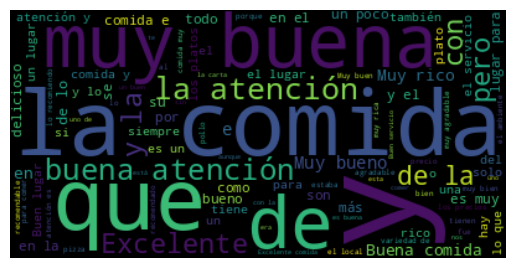

In [73]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(df['review']))

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()